In [ ]:
import os

import utils.classification_utils as classification_utils

import umap
import pandas as pd
import seaborn as sns
import IPython.display as ipd
import matplotlib.pyplot as plt

from dotenv import load_dotenv
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

load_dotenv()
sns.set_palette("Set2")

In [2]:
train_set_original = pd.read_csv(os.getenv('TRAIN_SET_ORIGINAL_PATH'), index_col=0, header=[0, 1, 2])
train_set_modified = pd.read_csv(os.getenv('TRAIN_SET_MODIFIED_PATH'), index_col=0, header=[0, 1, 2])

val_set = pd.read_csv(os.getenv('VALIDATION_SET_PATH'), index_col=0, header=[0, 1, 2])
test_set = pd.read_csv(os.getenv('TEST_SET_PATH'), index_col=0, header=[0, 1, 2])

In [3]:
print(train_set_original.shape, train_set_modified.shape, val_set.shape, test_set.shape)

(21572, 519) (20714, 519) (2397, 519) (5993, 519)


# Processing the datasets

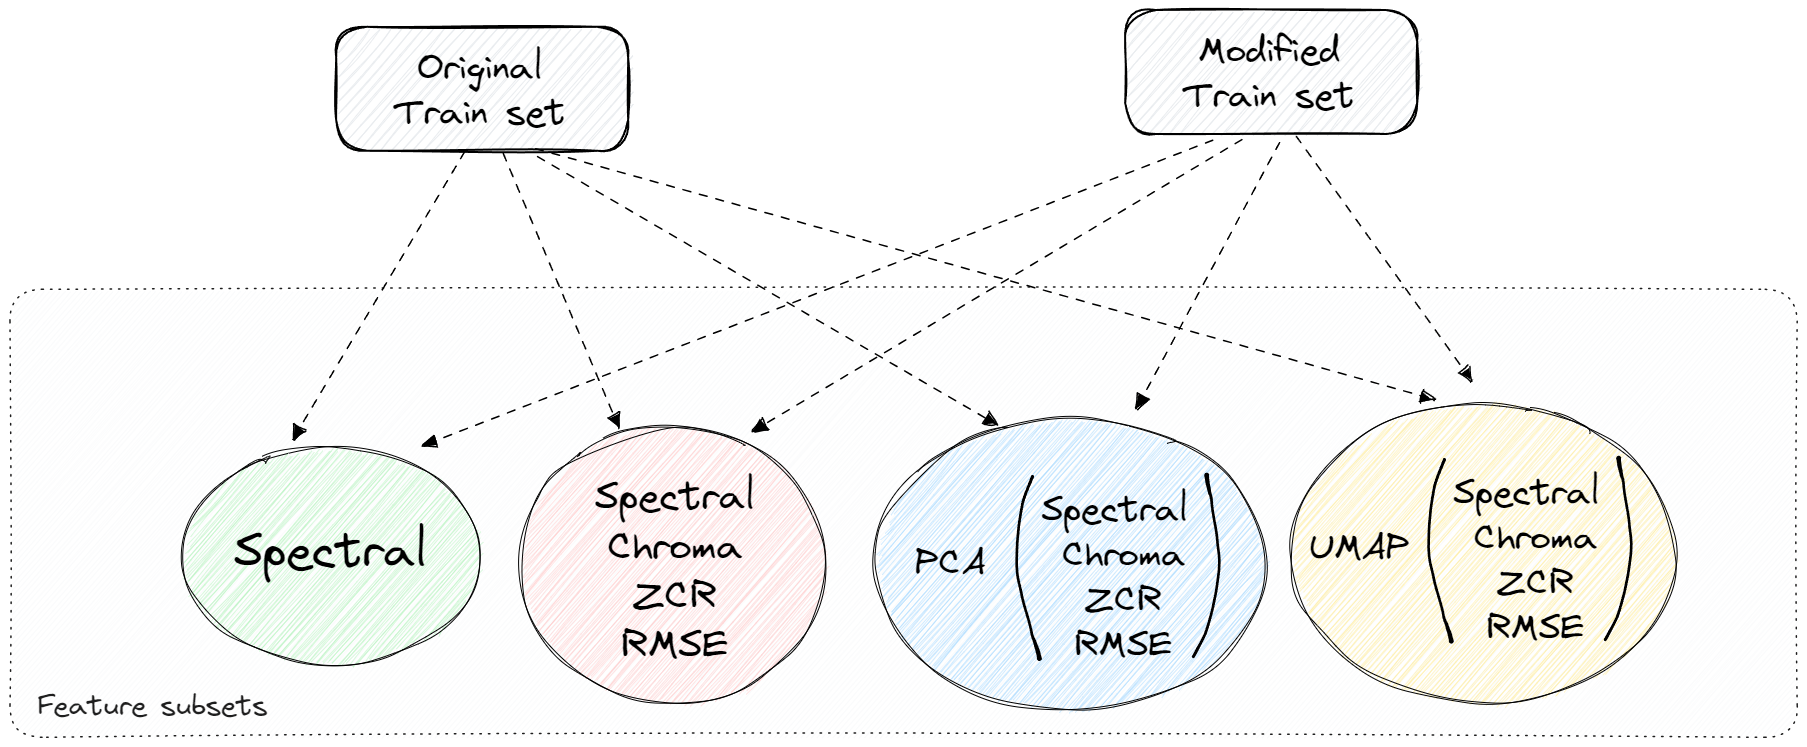

In [4]:
ipd.Image("images/feature_subset_datasets.png")

As concluded in the previous analysis, using all of the features available for training the classifiers may be reduntant. Hence we will experiment with different subsets of features, and train separate classifiers. We will construct the following datasets for both the original train set, as well as the modified train set, ending up with the total of 8 train (sub)sets.
1. Using Spectral Features Only (MFCC, Spectral Contrast, Spectral Rolloff)
2. Using Spectral Features, Chroma Features (chroma_cqt), ZCR, RMSE
3. PCA applied to Spectral Features, Chroma Features (chroma_cqt), ZCR, RMSE
4. UMAP applied to Spectral Features, Chroma Features (chroma_cqt), ZCR, RMSE

In [5]:
feature_subset_1 = ['mfcc', 'spectral_contrast', 'spectral_rolloff']
feature_subset_2 = ['mfcc', 'spectral_contrast', 'spectral_rolloff', 'chroma_cqt', 'zcr', 'rmse']

In [6]:
# 1. Spectral Features on original and modified datasets
train_spectral_original_X = train_set_original[feature_subset_1]
train_spectral_modified_X = train_set_modified[feature_subset_1]

val_spectral_X  = val_set[feature_subset_1]
test_spectral_X = test_set[feature_subset_1]

In [7]:
# 2. All Features on original and modified datasets
train_all_original_X = train_set_original[feature_subset_2]
train_all_modified_X = train_set_modified[feature_subset_2]

val_all_X  = val_set[feature_subset_2]
test_all_X = test_set[feature_subset_2]

In [8]:
# Helper functions for datasets 3 and 4
def scale_data(train_X, val_X, test_X, scaler):
    train_X = train_X.copy()
    val_X = val_X.copy()
    test_X = test_X.copy()

    train_X = pd.DataFrame(scaler.fit_transform(train_X), index=train_X.index, columns=train_X.columns)
    val_X   = pd.DataFrame(scaler.transform(val_X), index=val_X.index, columns=val_X.columns)
    test_X  = pd.DataFrame(scaler.transform(test_X), index=test_X.index, columns=test_X.columns)

    return train_X, val_X, test_X

def reduce_dataset(reducer, train_set, val_set, test_set, prefix):
    train_set, val_set, test_set = scale_data(train_set, val_set, test_set, StandardScaler())

    train_reduced = pd.DataFrame(
        reducer.fit_transform(train_set),
        index=train_set.index
    )
    train_reduced.columns = [f'{prefix}{i + 1}' for i in range(train_reduced.shape[1])]

    val_reduced = pd.DataFrame(
        reducer.transform(val_set),
        index=val_set.index,
    )
    val_reduced.columns = [f'{prefix}{i + 1}' for i in range(val_reduced.shape[1])]

    test_reduced = pd.DataFrame(
        reducer.transform(test_set),
        index=test_set.index,
    )
    test_reduced.columns = [f'{prefix}{i + 1}' for i in range(test_reduced.shape[1])]

    return train_reduced, val_reduced, test_reduced

In [9]:
# 3. PCA applied to all features

train_original_pca_X, val_original_pca_X, test_original_pca_X = reduce_dataset(
    reducer=PCA(n_components=0.95, random_state=23), 
    train_set=train_set_original[feature_subset_2], val_set=val_set[feature_subset_2], test_set=test_set[feature_subset_2],
    prefix='PC'
)

train_modified_pca_X, val_modified_pca_X, test_modified_pca_X = reduce_dataset(
    reducer=PCA(n_components=0.95, random_state=23), 
    train_set=train_set_modified[feature_subset_2], val_set=val_set[feature_subset_2], test_set=test_set[feature_subset_2],
    prefix='PC' 
)

In [10]:
print(train_original_pca_X.shape, val_original_pca_X.shape, test_original_pca_X.shape)
print(train_modified_pca_X.shape, val_modified_pca_X.shape, test_modified_pca_X.shape)

(21572, 141) (2397, 141) (5993, 141)
(20714, 140) (2397, 140) (5993, 140)


In [11]:
# 4. UMAP applied to all features

train_original_umap_X, val_original_umap_X, test_original_umap_X = reduce_dataset(
    reducer=umap.UMAP(n_neighbors=30, n_components=15, metric='cosine', min_dist=0.0),
    train_set=train_set_original[feature_subset_2], val_set=val_set[feature_subset_2], test_set=test_set[feature_subset_2],
    prefix='x'
)

train_modified_umap_X, val_modified_umap_X, test_modified_umap_X = reduce_dataset(
    reducer=umap.UMAP(n_neighbors=30, n_components=15, metric='cosine', min_dist=0.0), 
    train_set=train_set_modified[feature_subset_2], val_set=val_set[feature_subset_2], test_set=test_set[feature_subset_2],
    prefix='x' 
)

In [12]:
print(train_original_umap_X.shape, val_original_umap_X.shape, test_original_umap_X.shape)
print(train_modified_umap_X.shape, val_modified_umap_X.shape, test_modified_umap_X.shape)

(21572, 15) (2397, 15) (5993, 15)
(20714, 15) (2397, 15) (5993, 15)


# Summary
These are the resulting dataframes:
1. Dataframes involving spectral features only:
    - train_spectral_original_X
    - train_spectral_modified_X
    - val_spectral_X
    - test_spectral_X
2. Dataframes involving spectral features, chroma features, zcr and rmse
    - train_all_original_X
    - train_all_modified_X
    - val_all_X
    - test_all_X
3. Dataframes representing PCA applied to spectral features, chroma features, zcr and rmse:
    - train_original_pca_X
    - val_original_pca_X
    - test_original_pca_X
    - train_modified_pca_X
    - val_modified_pca_X
    - test_modified_pca_X
4. Dataframes representing UMAP applied to spectral features, chroma features, zcr and rmse:
    - train_original_umap_X
    - val_original_umap_X
    - test_original_umap_X
    - train_modified_umap_X
    - val_modified_umap_X
    - test_modified_umap_X

In [13]:
train_spectral_original_X.to_csv(os.getenv('train_spectral_original_X'))
train_spectral_modified_X.to_csv(os.getenv('train_spectral_modified_X'))
val_spectral_X.to_csv(os.getenv('val_spectral_X'))
test_spectral_X.to_csv(os.getenv('test_spectral_X'))

train_all_original_X.to_csv(os.getenv('train_all_original_X'))
train_all_modified_X.to_csv(os.getenv('train_all_modified_X'))
val_all_X.to_csv(os.getenv('val_all_X'))
test_all_X.to_csv(os.getenv('test_all_X'))

train_original_pca_X.to_csv(os.getenv('train_original_pca_X'))
val_original_pca_X.to_csv(os.getenv('val_original_pca_X'))
test_original_pca_X.to_csv(os.getenv('test_original_pca_X'))
train_modified_pca_X.to_csv(os.getenv('train_modified_pca_X'))
val_modified_pca_X.to_csv(os.getenv('val_modified_pca_X'))
test_modified_pca_X.to_csv(os.getenv('test_modified_pca_X'))

train_original_umap_X.to_csv(os.getenv('train_original_umap_X'))
val_original_umap_X.to_csv(os.getenv('val_original_umap_X'))
test_original_umap_X.to_csv(os.getenv('test_original_umap_X'))
train_modified_umap_X.to_csv(os.getenv('train_modified_umap_X'))
val_modified_umap_X.to_csv(os.getenv('val_modified_umap_X'))
test_modified_umap_X.to_csv(os.getenv('test_modified_umap_X'))